In [1]:
# %cd ..
import numpy as np, matplotlib.pyplot as plt, os
import inputs, simuls, analysis
results = analysis.GetResults(verbose=True)

# Fermi factor remover

"penEasy/input_decays.in" isotope file modified to Ga-68.nuc
PENNUC isotope reload done for Ga-68.nuc
"penEasy/pnnc_spec.dat" updated to Ga-68.nuc


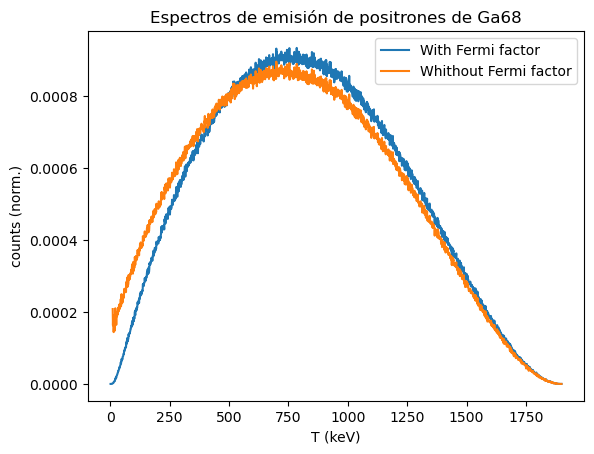

In [3]:
def fermi_remove(elem, elim, save=False):
    f_PES = "penEasy/pnnc_spec.dat"
    f_PEM = "penEasy/positrons.dat"
    f_fermi = f"fermi/{elem}_01.txt"

    """Since both PES and PEM are generated from PENNUC, we just use PEM and later modify PES"""
    # fermi factors
    fermi = np.loadtxt(f_fermi)[:,0:3:2]        # extract positron info
    fermi = fermi[fermi[:,0]<=elim]             # filter from 0 keV to elim keV
    fermi_ener = fermi[:,0]*1e3                # energy from MeV to keV
    fermi = fermi[:,1]                          # Fermi factors

    del_fermi =  fermi_ener[1] - fermi_ener[0]       

    # Energy profiles (in keV)
    nff_PEM = np.loadtxt(f_PEM)*1e-3                  # list of energies from eV to keV     
    EP_PEM = np.histogram(nff_PEM, bins=fermi_ener[:] + del_fermi/2)[0].astype('float64')  # apply Fermi to averages

    #normalisation
    EP_PEM /= np.sum(EP_PEM) * del_fermi
    FEP_PEM = EP_PEM[n-1:] / fermi[n:]
    FEP_PEM /= np.sum(FEP_PEM)

    if save:
        # penEasy SPC
        ff_PES = np.vstack((fermi_ener[n:]*1e3, FEP_PEM[:])).T      # recover eV from keV
        np.savetxt(f_PES, ff_PES, fmt=['%.4E', '%.8f'], header="Energy(eV)\tprobability", delimiter="\t")
        os.system(f"echo -e '{fermi_ener[-1]*1e3:.4E}\t-1' >> {f_PES}")  # add another line to delimit the end

        # penEasy MOD
        ff_PEM = np.random.choice(fermi_ener[n:], p=FEP_PEM[:], size=len(nff_PEM))      # resample
        ff_PEM *= 1e3           # recover eV from keV
        np.savetxt(f_PEM, ff_PEM, fmt=['%.6E'])

    return fermi_ener, fermi, EP_PEM, FEP_PEM

n=10     # index of first element to consider
iso = "Ga68"
elim = 1900  # keV      (650 F18-Cu64, 1900 Ga68-O15)
peneasy_inps.edit_isotope(pid, iso)
fermi_ener, fermi, EP_PEM, FEP_PEM = fermi_remove(iso, elim, save=False)

plt.plot(fermi_ener[1:], EP_PEM, label="With Fermi factor")
plt.plot(fermi_ener[n:], FEP_PEM, label="Whithout Fermi factor")
#plt.xlim(100, elim)
plt.legend()
plt.title(f"Espectros de emisión de positrones de {iso}")
plt.xlabel("T (keV)")
plt.ylabel("counts (norm.)")
plt.show()

# PenEasy SPC simulation

In [2]:
pid = 'SPC'
ver = '24'
# Initialize PenEasy Input Editor
peneasy_inps = inputs.PenEasy(verbose=True)

# Initialize Simulators (identified by pid)
peneasy_sims = simuls.PenEasy(verbose=True)
peneasy_sims.activate_pid(pid, ver)

penEasy 2024 SPC activated


In [5]:
MATS = {'water' : ['water', 1, 1.00+00]}
SIZE = [20]*3
STEP = [0.3]*3  #cm
nhist = "1e6"

peneasy_inps.edit_voxSize(pid, SIZE, STEP)
peneasy_inps.edit_seed(pid, 12345, 54321)
peneasy_inps.edit_mat(pid, MATS, SIZE, STEP)
peneasy_inps.edit_source_nhist(pid, nhist)

"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" coordinates of box center modified to (3, 3, 3)
"penEasy/phantomN.vox" voxel size modified to (0.3, 0.3, 0.3)
"penEasy/pen*.in" random seeds modified to 12345 and 54321
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" material modified to water
"penEasy/phantomN.vox" density modified to 1.00000000E+00
"penEasy/phantomN.vox" updated to water (case 1)
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" number of histories modified to 1e6
"penEasy/phantomN.vox" updated to point source of activity 1e6


In [6]:
isotopes = ["O15", "F18", "Cu64", "Ga68"]
elims = {"O15": 650, "F18": 650, "Cu64": 650, "Ga68": 1900}

peneasy_inps.verbose = False
for iso in isotopes:
    print(f"Simulating {iso}")
    res_folder = f"RESULTS/noCoulomb/Water/PenEasy20{ver}_xyz"
    peneasy_inps.edit_isotope(pid, iso)
    fermi_remove(iso, elims[iso], save=True)
    peneasy_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}.dat.original")

Simulating O15
penEasy 2024 SPC real time: 135.244 +- 0.000 s
Simulating F18
penEasy 2024 SPC real time: 111.105 +- 0.000 s
Simulating Cu64
penEasy 2024 SPC real time: 111.049 +- 0.000 s
Simulating Ga68
penEasy 2024 SPC real time: 135.007 +- 0.000 s


In [7]:
res_folder = f"RESULTS/noCoulomb/Water/PenEasy20{ver}_xyz"
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# Results analysis

In [8]:
program_folder = "PenEasy2024_xyz"
folder = f"RESULTS/noCoulomb/Water/{program_folder}"
trim = int(1e6)

rthresh = {"O15" : 9, "F18" : 3, "Cu64" : 4, "Ga68" : 10}  #water

for iso in rthresh.keys():
    if program_folder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]:
        continue
    print(f"Filtering {iso}")
    threshold = rthresh[iso] #mm
    analysis.filter_rmax(f"{folder}/{iso}.dat.original", f"{folder}/{iso}.dat", threshold=threshold, trim=trim, fmt='%.6f')

Filtering O15
Filtered 'RESULTS/Coulomb/Water/PenEasy2024_xyz/O15.dat.original' to 'RESULTS/Coulomb/Water/PenEasy2024_xyz/O15.dat': 0 points removed
Filtering F18
Filtered 'RESULTS/Coulomb/Water/PenEasy2024_xyz/F18.dat.original' to 'RESULTS/Coulomb/Water/PenEasy2024_xyz/F18.dat': 0 points removed
Filtering Cu64
Filtered 'RESULTS/Coulomb/Water/PenEasy2024_xyz/Cu64.dat.original' to 'RESULTS/Coulomb/Water/PenEasy2024_xyz/Cu64.dat': 0 points removed
Filtering Ga68
Filtered 'RESULTS/Coulomb/Water/PenEasy2024_xyz/Ga68.dat.original' to 'RESULTS/Coulomb/Water/PenEasy2024_xyz/Ga68.dat': 0 points removed


In [2]:
histo_bins = 1001
histo_step = .001 #cm
isotopes = ["O15", "F18", "Cu64", "Ga68"] 
pfolders = {
    # "PHITS 3.3":"PHITS_xyz",
    # "PenEasy 2020":"PenEasy2020_xyz",
    "PenEasy 2024":"PenEasy2024_xyz",
    # "PeneloPET 2024":"PeneloPET2024_xyz",
    # "GATE 9.2":"GATE92_xyz",
    # "GATE 9.3":"GATE93_xyz",
    # "GATE 7.0":"GATE7_xyz",
}
ffolders = {
    "W/ Fermi factor":"SPC",
    "W/o Fermi factor":"noCoulomb",
}

labels_iso = {iso:[] for iso in isotopes}
labels_prg = {p:[] for p in pfolders.keys()}
labels_fmi = {f:[] for f in ffolders.keys()}

results.active_results.clear()
for fmi, ffolder in ffolders.items():
    for iso in isotopes:
        for pname, pfolder in pfolders.items():
            if pfolder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]: continue
            # file with results
            rf = f"RESULTS/{ffolder}/Water/{pfolder}/{iso}.dat"
            # result label
            coul = "nC" if ffolder == "noCoulomb" else "C" 
            rl = f"{pname} {iso} {coul}"

            # load results
            results.load(rl, rf, [histo_bins]*3, [histo_step]*3)

            # append label to labels
            labels_iso[iso].append(rl)
            labels_prg[pname].append(rl)
            labels_fmi[fmi].append(rl)

PenEasy 2024 O15 C loaded
PenEasy 2024 F18 C loaded
PenEasy 2024 Cu64 C loaded
PenEasy 2024 Ga68 C loaded
PenEasy 2024 O15 nC loaded
PenEasy 2024 F18 nC loaded
PenEasy 2024 Cu64 nC loaded
PenEasy 2024 Ga68 nC loaded


In [3]:
results.data_analysis()

Size of annihilations sample:
     PenEasy 2024 O15 C                      	   1000000
     PenEasy 2024 F18 C                      	   1000000
     PenEasy 2024 Cu64 C                     	   1000000
     PenEasy 2024 Ga68 C                     	   1000000
     PenEasy 2024 O15 nC                     	   1000000
     PenEasy 2024 F18 nC                     	   1000000
     PenEasy 2024 Cu64 nC                    	   1000000
     PenEasy 2024 Ga68 nC                    	   1000000
Number of annihilation point coords:
     PenEasy 2024 O15 C                      	   1000000
     PenEasy 2024 F18 C                      	   1000000
     PenEasy 2024 Cu64 C                     	   1000000
     PenEasy 2024 Ga68 C                     	   1000000
     PenEasy 2024 O15 nC                     	   1000000
     PenEasy 2024 F18 nC                     	   1000000
     PenEasy 2024 Cu64 nC                    	   1000000
     PenEasy 2024 Ga68 nC                    	   1000000
Maximum radial distan

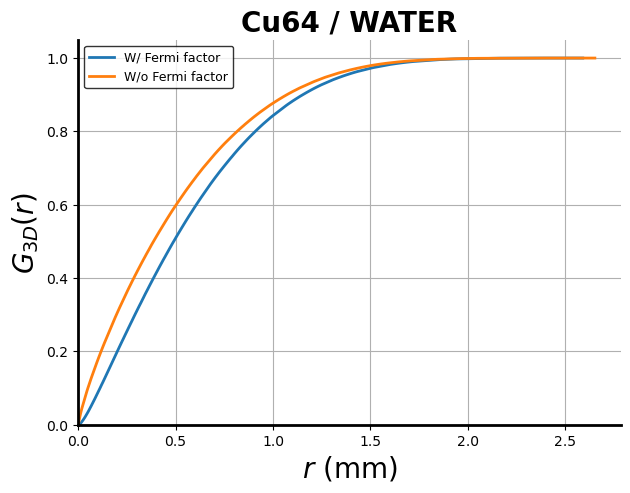

In [3]:
iso = "Cu64"
l = labels_iso[iso]
sl = list(labels_fmi.keys())
if iso not in ["C11", "O15", "F18"] and "GATE 7.0" in sl:
    sl.remove("GATE 7.0")
sl = dict(zip(l, sl))
plt.figure(figsize=(7,5))
results.plot_G3D_nohist(labels=l, sublabels=sl, title=f"{iso} / WATER")

isotope O15 : r0 = 1.99 mm, r1 = 4.27 mm, max dev = 4.1 %
isotope F18 : r0 = 0.39 mm, r1 = 1.04 mm, max dev = 6.6 %
isotope Cu64 : r0 = 0.48 mm, r1 = 1.14 mm, max dev = 20.6 %
isotope Ga68 : r0 = 2.33 mm, r1 = 4.82 mm, max dev = 11.8 %


/tmp/ipykernel_37614/3272009263.py:12: RuntimeWarning: divide by zero encountered in divide
  dev = (Cg3D-nCg3D) / Cg3D * 100     # in %


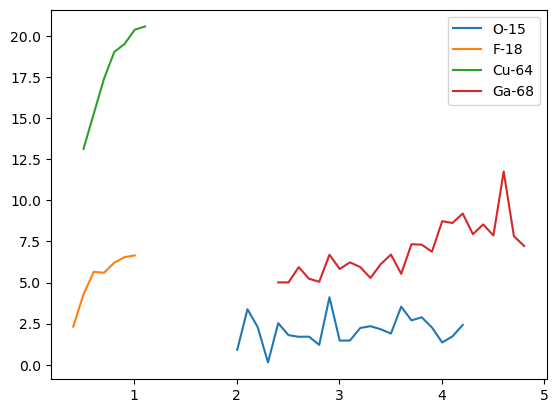

In [6]:
step = 1e-2 #cm
for iso in isotopes:
    C, nC = labels_iso[iso]
    C, nC = results.active_results[C], results.active_results[nC]
    maxPR = np.max([C.rmax, nC.rmax])
    histo_range = np.arange(0, maxPR+step, step)
    Cg3D,  r = np.histogram(C.rp,  bins=histo_range)
    nCg3D, r = np.histogram(nC.rp, bins=histo_range)
    r = r[:-1] + histo_step/2

    r *= 10  #cm to mm
    dev = (Cg3D-nCg3D) / Cg3D * 100     # in %
    r0 = C.interpol_G3D(0.5) * 10 #mm
    r1 = C.interpol_G3D(0.9) * 10  #cm to mm
    mask = (r >= r0) & (r <= r1)
    dev = dev[mask]
    r = r[mask]

    print(f"isotope {iso} : r0 = {r0:.2f} mm, r1 = {r1:.2f} mm, max dev = {np.max(dev):.1f} %")

    plt.plot(r, dev, label=f"{analysis.iso_in_plots(iso)}")

plt.legend()
plt.show()

isotope pair F18-Cu64 : r0 = 0.00 mm, r1 = 0.19 mm, max dev = 4.7 %
isotope pair O15-Ga68 : r0 = 0.00 mm, r1 = 1.23 mm, max dev = 14.3 %


/tmp/ipykernel_37614/2450965774.py:15: RuntimeWarning: divide by zero encountered in divide
  dev = abs(nCg3D1-nCg3D2) / nCg3D1 * 100     # in %
/tmp/ipykernel_37614/2450965774.py:15: RuntimeWarning: invalid value encountered in divide
  dev = abs(nCg3D1-nCg3D2) / nCg3D1 * 100     # in %


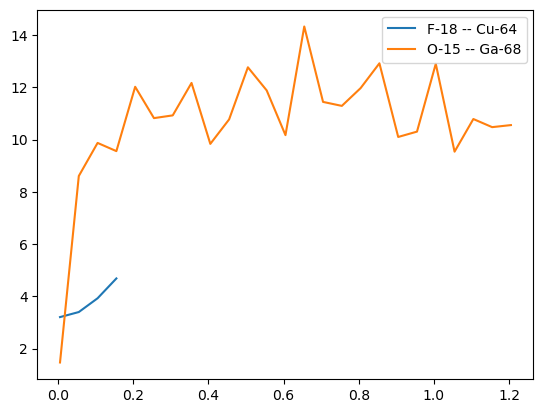

In [19]:
step = 5e-2/10 #cm
for iso1, iso2 in zip(["F18", "O15"], ["Cu64", "Ga68"]):
    C1, nC1 = labels_iso[iso1]
    C2, nC2 = labels_iso[iso2]
    C1, nC1 = results.active_results[C1], results.active_results[nC1]
    C2, nC2 = results.active_results[C2], results.active_results[nC2]

    maxPR = np.max([nC1.rmax, nC2.rmax])
    histo_range = np.arange(0, maxPR+step, step)
    nCg3D1, r = np.histogram(nC1.rp, bins=histo_range)
    nCg3D2, r = np.histogram(nC2.rp, bins=histo_range)
    r = r[:-1] + histo_step/2

    r *= 10  #cm to mm
    dev = abs(nCg3D1-nCg3D2) / nCg3D1 * 100     # in %
    r0 = 0#C.interpol_G3D(0.5) * 10 #mm
    r1 = np.mean([nC.interpol_G3D(0.3) for nC in [nC1, nC2]]) * 10  #cm to mm
    mask = (r >= r0) & (r <= r1)
    dev = dev[mask]
    r = r[mask]

    print(f"isotope pair {iso1}-{iso2} : r0 = {r0:.2f} mm, r1 = {r1:.2f} mm, max dev = {np.max(dev):.1f} %")

    plt.plot(r, dev, label=f"{analysis.iso_in_plots(iso1)} -- {analysis.iso_in_plots(iso2)}")

plt.legend()
plt.show()

/scratch/petgfn/Robert/PRcomp/analysis.py:206: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


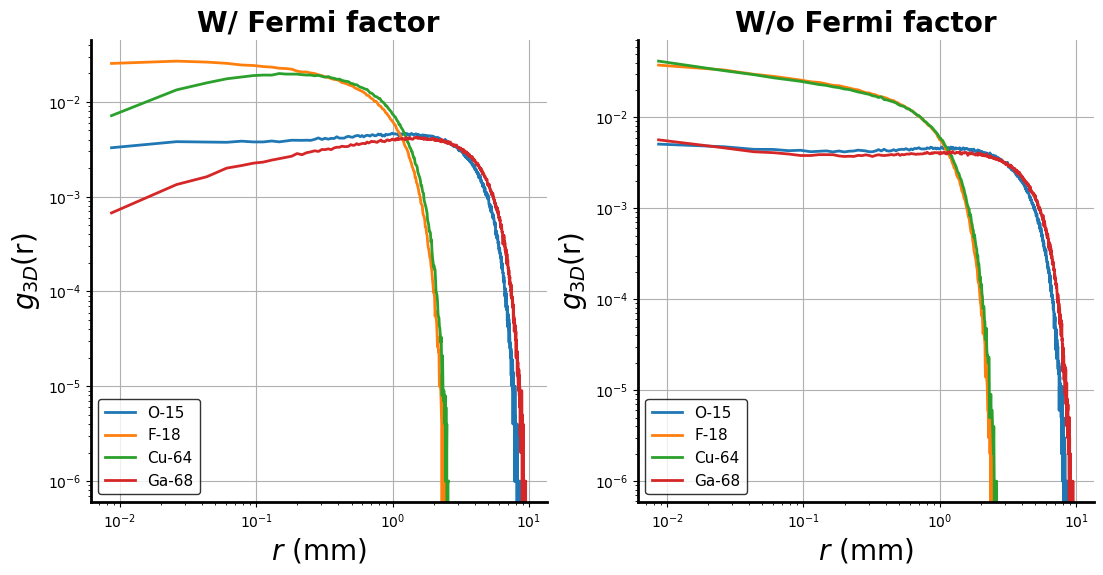

In [ ]:
isop = list(map(analysis.iso_in_plots, isotopes))
kmax = len(labels_prg)
max_cols = 3
max_rows = int(np.ceil(kmax/max_cols))
plt.figure(figsize=(20,6*max_rows))
for iso in isotopes:
    C, nC = labels_iso[iso]
    C, nC = results.active_results[C], results.active_results[nC]

for k, p in enumerate(labels_fmi.keys()):
    l = labels_fmi[p]
    sl = dict(zip(l, isop if p!="GATE 7.0" else ["C11", "O15", "F18"]))
    plt.subplot(max_rows, max_cols, k+1)
    results.plot_g3D(labels=l, sublabels=sl, title=f"{p}", log_scale=True)
    plt.xscale("log")
    ax, leg = analysis.aesthetic_plot(legend_size=11)
    ax.title.set_fontsize(20)
    ax.title.set_fontweight('bold')
    ax.set_xlabel(r"$r$ (mm)", fontsize=20)
    ax.set_ylabel(r"$g_{3D}$(r)", fontsize=20)
    leg.set_loc("lower left")

    plt.grid()

    for line in plt.gca().get_lines():
        line.set_linewidth(2)
plt.show()